In [110]:
import xarray as xr
import os


# Path to the saved ERA5 file
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
RAW_DATA_DIR = os.path.join(BASE_DIR, "data", "raw")


In [111]:
# Load raw GFDL-ESM4 subset
raw_cmip_path = os.path.join(RAW_DATA_DIR, "gfdl_esm4_tas_1940_2014_us.nc")
ds_cmip_raw = xr.open_dataset(raw_cmip_path)
print(ds_cmip_raw.data_vars)
#print(ds_cmip_raw.dims)
print("Dims:", ds_cmip_raw['tas'].dims)
print("Shape:", ds_cmip_raw['tas'].shape)
print("Min val:", ds_cmip_raw['tas'].isel(time=0).min().values)
print("Any non-NaN:", ~ds_cmip_raw['tas'].isel(time=0).isnull().all().values)

Data variables:
    tas      (time, lat, lon) float32 5MB ...
Dims: ('time', 'lat', 'lon')
Shape: (900, 25, 56)
Min val: 256.53714
Any non-NaN: True


In [112]:
cmip_tas_celsius = ds_cmip_raw['tas'] - 273.15
cmip_tas_celsius.name = "tas_celsius"

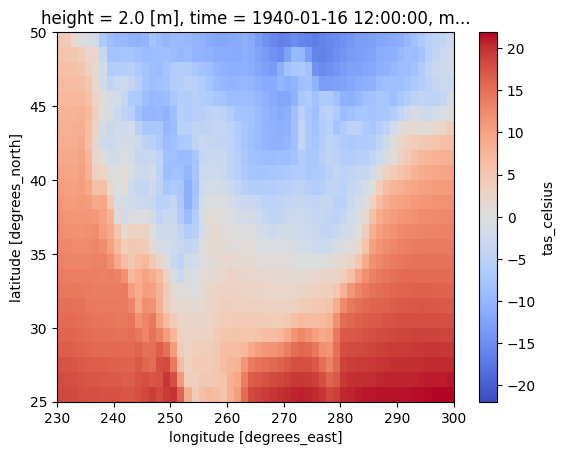

In [113]:
cmip_tas_celsius.isel(time=0).plot(cmap="coolwarm")

In [114]:

# Load ERA dataset
raw_era5_path = os.path.join(RAW_DATA_DIR, "era5_t2m_1940_2014_us.nc")
ds_era5_raw = xr.open_dataset(raw_era5_path)
print(ds_era5_raw.data_vars)
print(ds_era5_raw.dims)

era5_tas_celsius = ds_era5_raw['t2m'] - 273.15
era5_tas_celsius.name = "tas_celsius_era5"
print(era5_tas_celsius)



Data variables:
    t2m      (valid_time, latitude, longitude) float32 102MB ...
FrozenMappingWarningOnValuesAccess({'valid_time': 900, 'latitude': 101, 'longitude': 281})
<xarray.DataArray 'tas_celsius_era5' (valid_time: 900, latitude: 101,
                                      longitude: 281)> Size: 102MB
array([[[ 8.305389  ,  8.319061  ,  8.383514  , ..., -5.7375793 ,
         -5.5715637 , -5.5051575 ],
        [ 8.408905  ,  8.418671  ,  8.410858  , ..., -5.0403137 ,
         -4.9407043 , -4.8801575 ],
        [ 8.516327  ,  8.539764  ,  8.529999  , ..., -4.636017  ,
         -4.5364075 , -4.4934387 ],
        ...,
        [19.647186  , 19.596405  , 19.576874  , ..., 22.307343  ,
         22.29367   , 22.26828   ],
        [19.719452  , 19.666718  , 19.639374  , ..., 22.447968  ,
         22.428436  , 22.38742   ],
        [19.807343  , 19.748749  , 19.721405  , ..., 22.567108  ,
         22.535858  , 22.496796  ]],

       [[ 6.346344  ,  6.4166565 ,  6.531891  , ..., -9.530609  

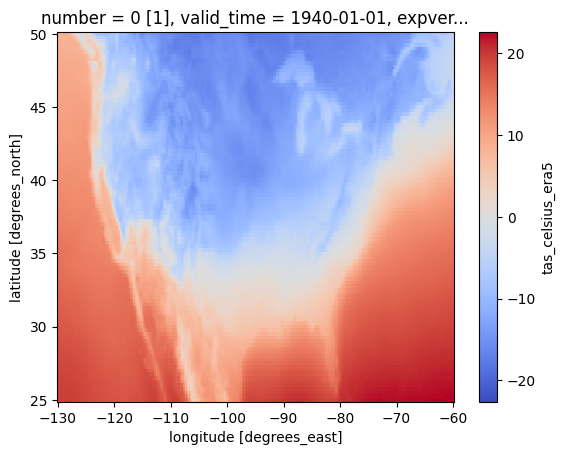

In [115]:
era5_tas_celsius.isel(valid_time=0).plot(cmap="coolwarm")


In [116]:
print("Lat:", era5_tas_celsius.latitude.values.min(), "to", era5_tas_celsius.latitude.values.max())
print("Lon:", era5_tas_celsius.longitude.values.min(), "to", era5_tas_celsius.longitude.values.max())


Lat: 25.0 to 50.0
Lon: -130.0 to -60.0


In [117]:
import xesmf as xe

# Prepare source and target grids
era5_grid = {
    'lon': era5_tas_celsius.longitude,
    'lat': era5_tas_celsius.latitude
}

cmip_grid = {
    'lon': cmip_tas_celsius.lon,
    'lat': cmip_tas_celsius.lat
}

# Build regridder (1st time creates weights)
regridder = xe.Regridder(era5_tas_celsius, cmip_tas_celsius, method='bilinear', periodic=True)

# Apply to ERA5 temperature
tas_era5_regridded = regridder(era5_celsius)
tas_era5_regridded.name = "tas_celsius_era5_regridded"
print(tas_era5_regridded)


<xarray.DataArray 'tas_celsius_era5_regridded' (valid_time: 900, lat: 25,
                                                lon: 56)> Size: 5MB
array([[[ 19.583723  ,  19.616924  ,  19.405012  , ...,  22.171629  ,
          22.233154  ,  22.30542   ],
        [ 19.32201   ,  19.154049  ,  19.069084  , ...,  21.653076  ,
          21.685307  ,  21.672611  ],
        [ 18.802488  ,  18.870836  ,  18.668695  , ...,  20.91774   ,
          21.031013  ,  21.090582  ],
        ...,
        [  9.442144  ,   9.559332  ,   9.340568  , ...,  -5.059854  ,
          -4.2639475 ,  -3.5149283 ],
        [  9.059324  ,   8.940198  ,   8.832765  , ...,  -5.281498  ,
          -4.53148   ,  -3.8566844 ],
        [  8.507568  ,   8.367899  ,   7.7665467 , ...,  -9.31627   ,
          -6.076506  ,  -4.72772   ]],

       [[ 18.460619  ,  18.426445  ,  18.219414  , ...,  21.262396  ,
          21.36787   ,  21.386421  ],
        [ 18.06805   ,  17.869814  ,  17.772154  , ...,  20.618845  ,
          20.6334

ERA5 shape (after regrid): (900, 25, 56)
CMIP6 shape: (900, 0, 56)


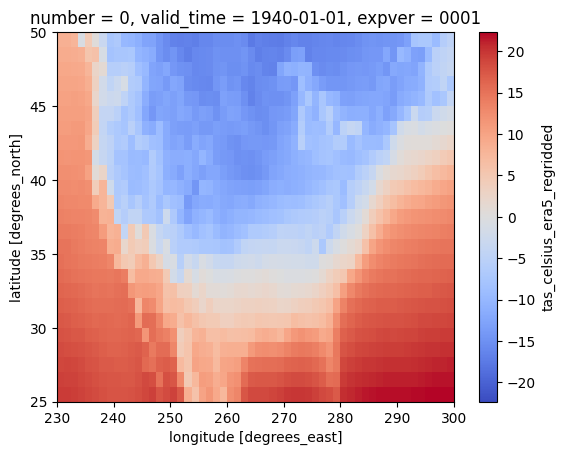

In [118]:
# Shapes should now match
print("ERA5 shape (after regrid):", tas_era5_regridded.shape)
print("CMIP6 shape:", tas_cmip.shape)

# Plot a sample
tas_era5_regridded.isel(valid_time=0).plot(cmap="coolwarm")


In [120]:
PROCESSED_DATA_DIR = os.path.join(BASE_DIR, "data", "processed")
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# Save regridded ERA5 and original CMIP6
tas_era5_regridded.to_netcdf(os.path.join(PROCESSED_DATA_DIR, "era5_regridded_tas_1940_2014_us.nc"))
cmip_tas_celsius.to_netcdf(os.path.join(PROCESSED_DATA_DIR, "gfdl_esm4_tas_celsius_1940_2014_us.nc"))
